In [1]:
import pandas as pd
import torch
from torch import cuda
import seqeval
from seqeval.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from datasets import load_dataset
import ast
from transformers import Trainer
from transformers import TrainingArguments

In [2]:
# 60 train, 20 dev, 20 test
train_df = pd.read_csv('data/processed/phee/ace/train_w_test_tag_new_mapped.csv')
dev_df = pd.read_csv('data/processed/phee/ace/dev_w_test_tag_new_mapped.csv')
test_df = pd.read_csv('data/processed/phee/ace/test_w_test_tag_new_mapped.csv')


# train_df = train_df[['Sentence', 'Med_Tag']]
# train_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
# dev_df = dev_df[['Sentence', 'Med_Tag']]
# dev_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
# test_df = test_df[['Sentence', 'Med_Tag']]
# test_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)

train_df['sentence'] = train_df['sentence'].apply(lambda x: x.split())
train_df['tag'] = train_df['tag'].apply(lambda x: x.split())
dev_df['sentence'] = dev_df['sentence'].apply(lambda x: x.split())
dev_df['tag'] = dev_df['tag'].apply(lambda x: x.split())
test_df['sentence'] = test_df['sentence'].apply(lambda x: x.split())
test_df['tag'] = test_df['tag'].apply(lambda x: x.split())

train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)

# save to csv
train_dev_df.to_csv('data/processed/phee/ace/final_train.csv', index=False) # final_train is train+dev
test_df.to_csv('data/processed/phee/ace/final_dev.csv', index=False) # final_dev is test
test_df.to_csv('data/processed/phee/ace/final_test.csv', index=False) # final_test is test
# train_dev_df


In [3]:
train_dev_df

,sentence,tag
0,"[objective, :, to, test, the, hypothesis, that...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[an, evaluation, of, ovarian, structure, and, ...","[O, I-Test, I-Test, O, O, O, O, O, O, O, O, I-..."
2,"[phenobarbital, hepatotoxicity, in, an, 8, -, ...","[I-Treatment, I-Problem, O, I-Background, I-Ba..."
3,"[the, authors, report, a, case, of, balint, sy...","[O, O, O, O, O, O, I-Problem, I-Problem, I-Pro..."
4,"[according, to, the, naranjo, probability, sca...","[O, O, O, O, I-Test, I-Test, O, I-Treatment, O..."
...,...,...
3706,"[successful, challenge, with, clozapine, in, a...","[O, O, O, I-Treatment, O, O, O, O, I-Problem, O]"
3707,"[case, summary, :, a, 57, -, year, -, old, fem...","[O, O, O, I-Background, I-Background, I-Backgr..."
3708,"[acute, intravascular, hemolysis, developed, w...","[I-Problem, I-Problem, I-Problem, O, O, I-Back..."
3709,"[intravitreal, triamcinolone, may, have, had, ...","[I-Treatment, I-Treatment, O, O, O, O, O, O, O..."


In [4]:
label2id = {'O': 0,
 'I-Treatment': 1,
 'I-Test': 2,
 'I-Problem': 3,
 'I-Background': 4,
 'I-Other': 5}

In [5]:
# combined_df = pd.concat([train_dev_df, test_df], ignore_index=True)

# def convert_tags_to_ids(row, tag_to_id):
#     return [tag_to_id[tag] for tag in row]

# # Applying the conversion
# combined_df['tag'] = combined_df['tag'].apply(lambda row: convert_tags_to_ids(row, label2id))
# combined_df

In [6]:
# import pandas as pd

# # Assuming df is your DataFrame
# # Replace 'df' with the actual name of your DataFrame variable
# # rename columns of dataframe to
# combined_df.rename(columns={"sentence": "tokens", "tag": "ner_tags"}, inplace=True)
# # Convert DataFrame to list of dictionaries
# data_list = combined_df[:5].to_dict(orient='records')

# # Create the final dictionary with version and data
# json_data = {
#     "version": "0.1.0",
#     "data": data_list
# }

# # To convert this dictionary to a JSON string
# import json
# json_output = json.dumps(json_data, indent=2)

# # Print the JSON string to check
# print(json_output)

# # To save this to a JSON file
# with open('med_highlight.json', 'w') as file:
#     file.write(json_output)


In [7]:
# datt = load_dataset('json', data_files='med_highlight.json', field='data')
# datt

In [8]:
# import pandas as pd

# def dataframe_to_conll(df, token_col='tokens', tag_col='tags'):
#     conll_format = ""

#     for _, row in df.iterrows():
#         tokens = row[token_col]
#         tags = row[tag_col]

#         for token, tag in zip(tokens, tags):
#             conll_format += f"{token}\t{tag}\n"
        
#         conll_format += "\n"  # Separate sentences by a blank line

#     return conll_format

# # Assuming df is your DataFrame
# conll_data = dataframe_to_conll(train_dev_df, token_col='sentence', tag_col='tag')

# # To see the result
# print(conll_data[:500])  # Print first 500 characters to check

# # To save to a file
# with open('conll', 'w') as file:
#     file.write(conll_data)

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
# load 'data/processed/phee/ace/final_dev.csv'
dev_dataset = pd.read_csv('data/processed/phee/ace/final_dev.csv')
sum(dev_dataset['tag'].map(lambda x: ast.literal_eval(x)).map(lambda x: len(x)))

21795

In [11]:
dataset = load_dataset('csv', data_files={'train': 'data/processed/phee/ace/final_train.csv', 'validation': 'data/processed/phee/ace/final_dev.csv', 'test': 'data/processed/phee/ace/final_test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [12]:
unique_tags = pd.unique([tag for sublist in train_df['tag'] for tag in sublist])
# Create label2id dictionary
print(unique_tags)
label2id = {tag: id for id, tag in enumerate(unique_tags)}

# Create id2label dictionary by swapping keys with values
id2label = {id: tag for tag, id in label2id.items()}

# Print the dictionaries
print("label2id:", label2id)
print("id2label:", id2label)

['O' 'I-Treatment' 'I-Test' 'I-Problem' 'I-Background' 'I-Other']
label2id: {'O': 0, 'I-Treatment': 1, 'I-Test': 2, 'I-Problem': 3, 'I-Background': 4, 'I-Other': 5}
id2label: {0: 'O', 1: 'I-Treatment', 2: 'I-Test', 3: 'I-Problem', 4: 'I-Background', 5: 'I-Other'}


In [13]:
train_df['sentence']

0       [objective, :, to, test, the, hypothesis, that...
1       [an, evaluation, of, ovarian, structure, and, ...
2       [phenobarbital, hepatotoxicity, in, an, 8, -, ...
3       [the, authors, report, a, case, of, balint, sy...
4       [according, to, the, naranjo, probability, sca...
                              ...                        
2788    [l, -, t4, stimulated, lymphocyte, transformat...
2789    [a, 53, -, year, -, old, man, developed, lower...
2790    [a, mentally, retarded, 23, -, year, -, old, w...
2791    [after, 5, days, of, treatment, with, il, -, 2...
2792    [acute, pancreatitis, after, long, -, term, 5,...
Name: sentence, Length: 2793, dtype: object

In [14]:
def transform(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])
    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

for type in ['train', 'validation', 'test']:
    dataset[type] = dataset[type].map(transform)

Map:   0%|          | 0/3711 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [15]:
tokenizer = AutoTokenizer.from_pretrained("samrawal/bert-base-uncased_clinical-ner")

In [16]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

In [46]:
# labels =  dataset['train'][0]['tag']
# word_ids = inputs.word_ids()
# print(labels)
# print(align_labels_with_tokens(labels, word_ids))

In [17]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [19]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names,
)

Map:   0%|          | 0/3711 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [20]:
tokenized_datasets.column_names

{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}

In [21]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,    0,    0,    2,    2,    2,    2,    2,    0,    0,
            3,    3,    3,    0,    0,    0,    0,    0,    0, -100],
        [-100,    0,    2,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    4,    4,    4,    4,    0,    0,    0,    1,    1,    1,
            1,    3,    3,    3,    0,    0,    0,    0,    0,    3,    3,    3,
            3,    3,    3,    0,    0,    0, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [32]:
metric = evaluate.load("seqeval")

In [39]:
predictions = [['O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-h']]
references = [['O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-h']]

In [40]:
import seqeval.metrics 
print(seqeval.metrics.classification_report(references, predictions)  )

              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00         1
           h       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [25]:
def untokenize_labels_predictions(word_ids, true_labels, predictions):
    untokenized_true_labels = []
    untokenized_predictions = []

    for sublist_word_ids, sublist_true_labels, sublist_predictions in zip(word_ids, true_labels, predictions):
        current_labels = []
        current_predictions = []
        last_word_id = None

        for word_id, label, prediction in zip(sublist_word_ids, sublist_true_labels, sublist_predictions):
            # Skip if this word_id is the same as the last one (it's a subword)
            if word_id == last_word_id:
                continue

            current_labels.append(label)
            current_predictions.append(prediction)
            last_word_id = word_id

        untokenized_true_labels.append(current_labels)
        untokenized_predictions.append(current_predictions)

    return untokenized_true_labels, untokenized_predictions


In [26]:
val_sentences = dataset['validation']['sentence']
val_word_ids = []
for sentence in val_sentences:
    val_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())



In [41]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    untokenized_true_labels, untokenized_predictions = untokenize_labels_predictions(val_word_ids, true_labels, true_predictions)
                
                
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    
    span_report = seqeval.metrics.classification_report(untokenized_true_labels, untokenized_predictions)
    print("SPAN REPORT")
    print(span_report)
    
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in true_predictions for label in seq]
    report = classification_report(y_pred=flat_pred, y_true=flat_true, output_dict=True)
    report['macro_wo_O'] = {'precision': (report['I-Background']['precision'] + report['I-Other']['precision'] + report['I-Problem']['precision'] + report['I-Test']['precision'] + report['I-Treatment']['precision']) / 5,
    'recall': (report['I-Background']['recall'] + report['I-Other']['recall'] + report['I-Problem']['recall'] + report['I-Test']['recall'] + report['I-Treatment']['recall']) / 5,
    'f1-score': (report['I-Background']['f1-score'] + report['I-Other']['f1-score'] + report['I-Problem']['f1-score'] + report['I-Test']['f1-score'] + report['I-Treatment']['f1-score']) / 5,
    'support': (report['I-Background']['support'] + report['I-Other']['support'] + report['I-Problem']['support'] + report['I-Test']['support'] + report['I-Treatment']['support'])}
    
    report_df = pd.DataFrame(report).round(3).T


    unflat_true = [label for seq in untokenized_true_labels for label in seq]
    unflat_pred = [label for seq in untokenized_predictions for label in seq]
    unreport = classification_report(y_pred=unflat_pred, y_true=unflat_true, output_dict=True)
    unreport['macro_wo_O'] = {'precision': (unreport['I-Background']['precision'] + unreport['I-Other']['precision'] + unreport['I-Problem']['precision'] + unreport['I-Test']['precision'] + unreport['I-Treatment']['precision']) / 5,
    'recall': (unreport['I-Background']['recall'] + unreport['I-Other']['recall'] + unreport['I-Problem']['recall'] + unreport['I-Test']['recall'] + unreport['I-Treatment']['recall']) / 5,
    'f1-score': (unreport['I-Background']['f1-score'] + unreport['I-Other']['f1-score'] + unreport['I-Problem']['f1-score'] + unreport['I-Test']['f1-score'] + unreport['I-Treatment']['f1-score']) / 5,
    'support': (unreport['I-Background']['support'] + unreport['I-Other']['support'] + unreport['I-Problem']['support'] + unreport['I-Test']['support'] + unreport['I-Treatment']['support'])}
    
    un_report_df = pd.DataFrame(unreport).round(3).T

    # accuracy_score_val = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    cm = confusion_matrix(y_pred=flat_pred, y_true=flat_true)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['I-Background','I-Other', 'I-Problem', 'I-Test', 'I-Treatment', 'O']))
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax)

    # Save the figure to an image file
    plt.savefig('analysis/graphs/confusion_matrix.png')
    plt.show()
    print("TOKENIZED REPORT")
    print(report_df)
    print("UNTOKENIZED REPORT")
    print(un_report_df)
    # save all_metrics to file
    with open("analysis/reports/all_metrics.txt", "w") as f:
        f.write(str(all_metrics))
        # save report to file
        f.write(str(report_df))

    return {
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1": report['macro avg']['f1-score'],
        "accuracy": report['accuracy'],
    }

In [42]:
model = AutoModelForTokenClassification.from_pretrained(
    'samrawal/bert-base-uncased_clinical-ner',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
# from huggingface_hub import notebook_login

# notebook_login()

In [29]:


# args = TrainingArguments(
#     "bert-finetuned-ner",
#     overwrite_output_dir=True,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     num_train_epochs=5,
#     weight_decay=0.01,
# )

In [43]:
args = TrainingArguments(
    "bert-finetuned-ner",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_strategy="epoch",
)

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.497600,0.402324,0.820974,0.765187,0.789536,0.854145
2,0.326000,0.386946,0.833988,0.775124,0.801834,0.861918
3,0.267500,0.387425,0.822197,0.794923,0.807488,0.867004
4,0.228800,0.401882,0.828911,0.792999,0.809144,0.869051
5,0.205100,0.407734,0.832596,0.797511,0.813415,0.870234


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.55      0.54      0.55       491
       Other       0.41      0.36      0.39       129
     Problem       0.62      0.71      0.66      1309
        Test       0.61      0.44      0.51       104
   Treatment       0.57      0.64      0.61      1087

   micro avg       0.58      0.64      0.61      3120
   macro avg       0.55      0.54      0.54      3120
weighted avg       0.58      0.64      0.61      3120



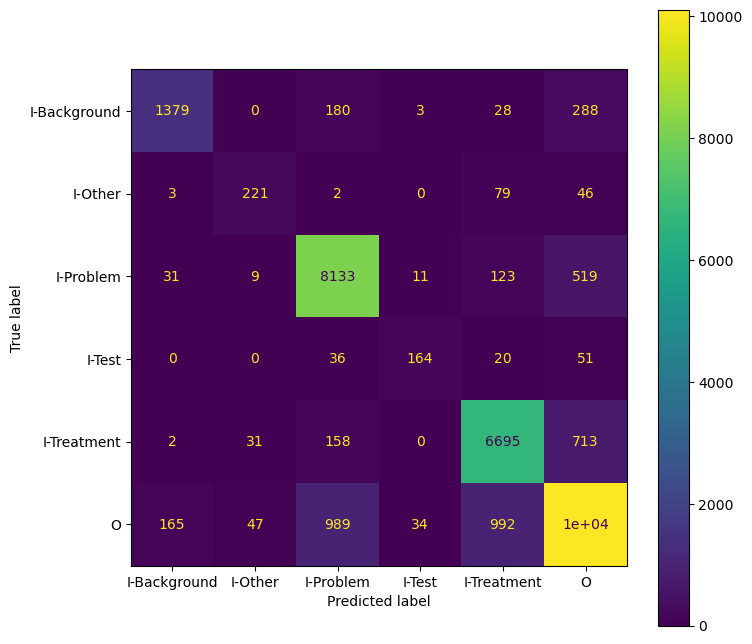

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.873   0.734     0.798   1878.000
I-Other           0.718   0.630     0.671    351.000
I-Problem         0.856   0.921     0.888   8826.000
I-Test            0.774   0.605     0.679    271.000
I-Treatment       0.844   0.881     0.862   7599.000
O                 0.862   0.820     0.840  12339.000
accuracy          0.854   0.854     0.854      0.854
macro avg         0.821   0.765     0.790  31264.000
weighted avg      0.854   0.854     0.853  31264.000
macro_wo_O        0.813   0.754     0.779  18925.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.872   0.760     0.813   1682.000
I-Other           0.728   0.628     0.674    320.000
I-Problem         0.837   0.903     0.869   5156.000
I-Test            0.837   0.591     0.693    208.000
I-Treatment       0.819   0.855     0.837   4245.000
O                 0.864   0.839     0.851   9216.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.56      0.57      0.56       491
       Other       0.47      0.43      0.45       129
     Problem       0.64      0.72      0.68      1309
        Test       0.60      0.49      0.54       104
   Treatment       0.61      0.65      0.63      1087

   micro avg       0.61      0.65      0.63      3120
   macro avg       0.58      0.57      0.57      3120
weighted avg       0.61      0.65      0.63      3120



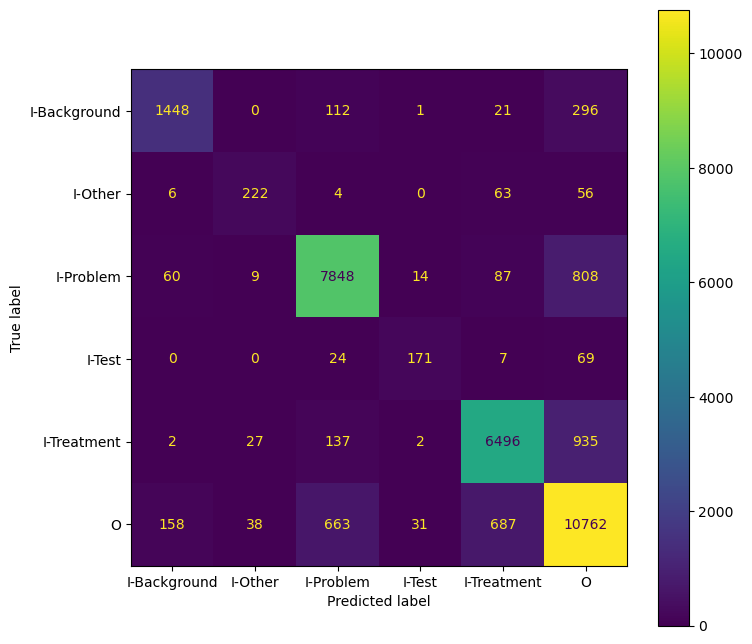

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.865   0.771     0.815   1878.000
I-Other           0.750   0.632     0.686    351.000
I-Problem         0.893   0.889     0.891   8826.000
I-Test            0.781   0.631     0.698    271.000
I-Treatment       0.882   0.855     0.868   7599.000
O                 0.833   0.872     0.852  12339.000
accuracy          0.862   0.862     0.862      0.862
macro avg         0.834   0.775     0.802  31264.000
weighted avg      0.862   0.862     0.862  31264.000
macro_wo_O        0.834   0.756     0.792  18925.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.866   0.788     0.825   1682.000
I-Other           0.764   0.628     0.690    320.000
I-Problem         0.879   0.864     0.871   5156.000
I-Test            0.840   0.606     0.704    208.000
I-Treatment       0.864   0.826     0.845   4245.000
O                 0.837   0.887     0.861   9216.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.56      0.61      0.58       491
       Other       0.45      0.45      0.45       129
     Problem       0.65      0.73      0.69      1309
        Test       0.60      0.50      0.54       104
   Treatment       0.61      0.67      0.64      1087

   micro avg       0.62      0.67      0.64      3120
   macro avg       0.57      0.59      0.58      3120
weighted avg       0.61      0.67      0.64      3120



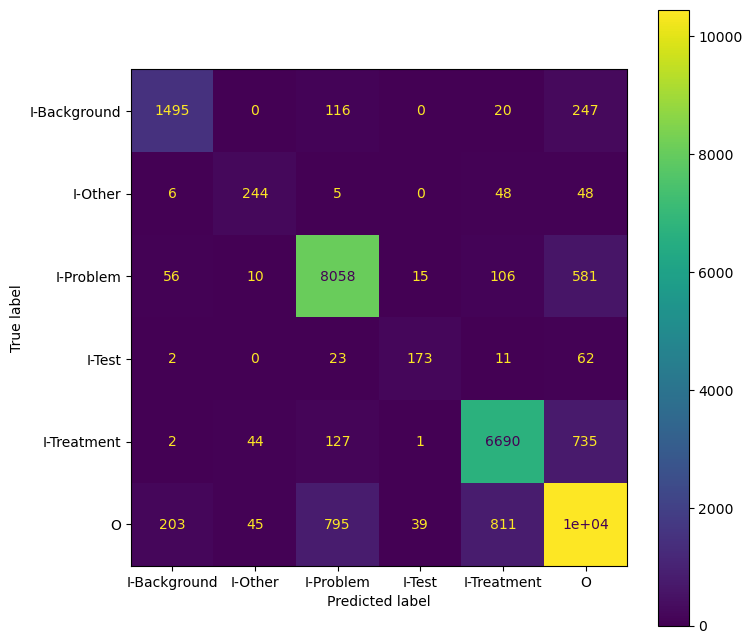

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.848   0.796     0.821   1878.000
I-Other           0.711   0.695     0.703    351.000
I-Problem         0.883   0.913     0.898   8826.000
I-Test            0.759   0.638     0.693    271.000
I-Treatment       0.870   0.880     0.875   7599.000
O                 0.862   0.847     0.854  12339.000
accuracy          0.867   0.867     0.867      0.867
macro avg         0.822   0.795     0.807  31264.000
weighted avg      0.867   0.867     0.867  31264.000
macro_wo_O        0.814   0.785     0.798  18925.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.852   0.812     0.831   1682.00
I-Other           0.718   0.694     0.706    320.00
I-Problem         0.865   0.894     0.879   5156.00
I-Test            0.823   0.625     0.710    208.00
I-Treatment       0.853   0.857     0.855   4245.00
O                 0.867   0.861     0.864   9216.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.55      0.64      0.59       491
       Other       0.46      0.46      0.46       129
     Problem       0.66      0.73      0.69      1309
        Test       0.65      0.51      0.57       104
   Treatment       0.62      0.67      0.65      1087

   micro avg       0.62      0.68      0.65      3120
   macro avg       0.59      0.60      0.59      3120
weighted avg       0.62      0.68      0.65      3120



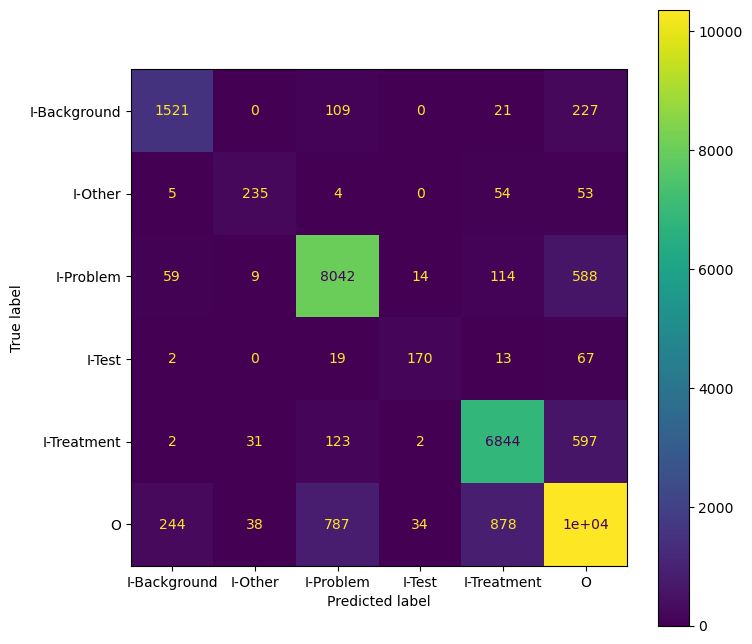

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.830   0.810     0.820   1878.000
I-Other           0.751   0.670     0.708    351.000
I-Problem         0.885   0.911     0.898   8826.000
I-Test            0.773   0.627     0.692    271.000
I-Treatment       0.864   0.901     0.882   7599.000
O                 0.871   0.839     0.855  12339.000
accuracy          0.869   0.869     0.869      0.869
macro avg         0.829   0.793     0.809  31264.000
weighted avg      0.869   0.869     0.868  31264.000
macro_wo_O        0.820   0.784     0.800  18925.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.835   0.828     0.831   1682.000
I-Other           0.756   0.669     0.710    320.000
I-Problem         0.869   0.892     0.880   5156.000
I-Test            0.821   0.615     0.703    208.000
I-Treatment       0.844   0.882     0.863   4245.000
O                 0.875   0.854     0.864   9216.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.56      0.63      0.60       491
       Other       0.50      0.50      0.50       129
     Problem       0.66      0.72      0.69      1309
        Test       0.61      0.51      0.55       104
   Treatment       0.63      0.68      0.65      1087

   micro avg       0.63      0.68      0.65      3120
   macro avg       0.59      0.61      0.60      3120
weighted avg       0.63      0.68      0.65      3120



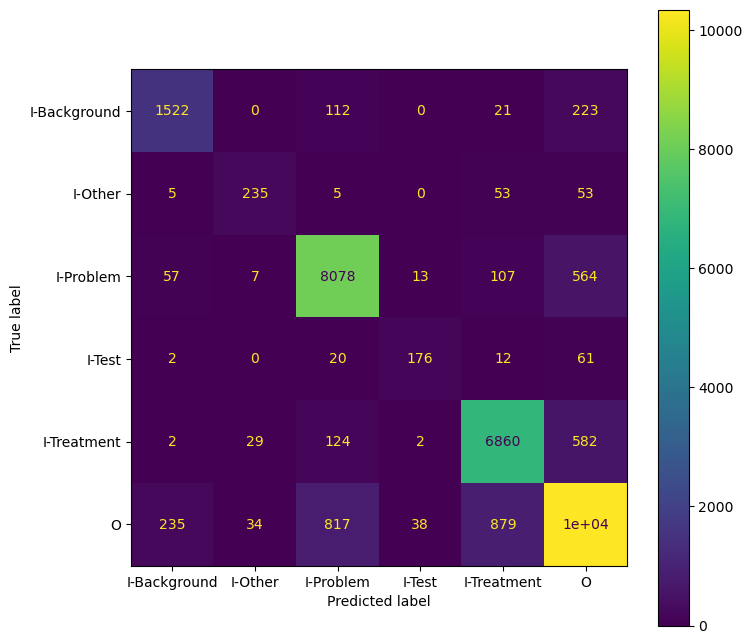

TOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.835   0.810     0.822   1878.00
I-Other           0.770   0.670     0.716    351.00
I-Problem         0.882   0.915     0.898   8826.00
I-Test            0.769   0.649     0.704    271.00
I-Treatment       0.865   0.903     0.883   7599.00
O                 0.875   0.838     0.856  12339.00
accuracy          0.870   0.870     0.870      0.87
macro avg         0.833   0.798     0.813  31264.00
weighted avg      0.870   0.870     0.870  31264.00
macro_wo_O        0.824   0.789     0.805  18925.00
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.839   0.827     0.833   1682.000
I-Other           0.778   0.669     0.719    320.000
I-Problem         0.865   0.896     0.880   5156.000
I-Test            0.811   0.639     0.715    208.000
I-Treatment       0.845   0.886     0.865   4245.000
O                 0.878   0.851     0.864   9216.000
accuracy          0.8

TrainOutput(global_step=2320, training_loss=0.30500332733680463, metrics={'train_runtime': 550.8765, 'train_samples_per_second': 33.683, 'train_steps_per_second': 4.211, 'total_flos': 527858951087520.0, 'train_loss': 0.30500332733680463, 'epoch': 5.0})

In [44]:


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


SPAN REPORT
              precision    recall  f1-score   support

  Background       0.55      0.63      0.59       491
       Other       0.48      0.48      0.48       129
     Problem       0.67      0.74      0.70      1309
        Test       0.65      0.52      0.58       104
   Treatment       0.64      0.69      0.66      1087

   micro avg       0.63      0.69      0.66      3120
   macro avg       0.60      0.61      0.60      3120
weighted avg       0.63      0.69      0.66      3120



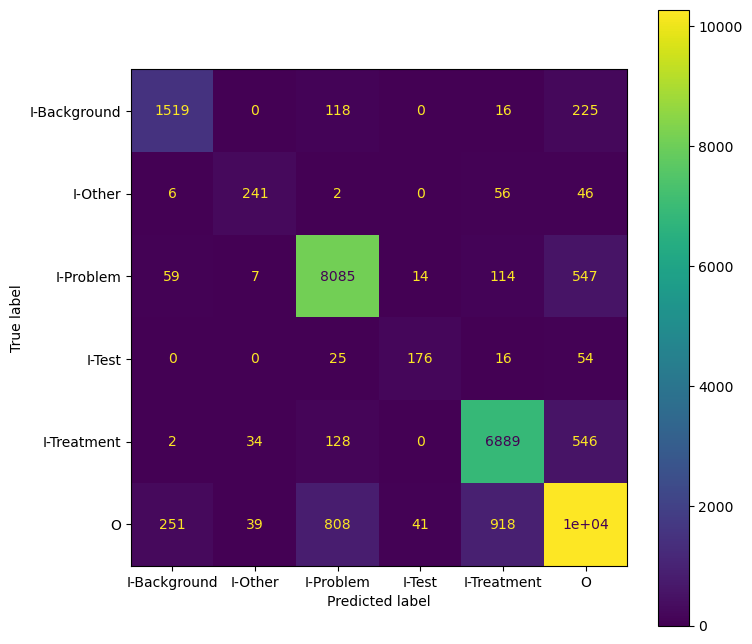

              precision  recall  f1-score   support
I-Background      0.827   0.809     0.818   1878.00
I-Other           0.751   0.687     0.717    351.00
I-Problem         0.882   0.916     0.899   8826.00
I-Test            0.762   0.649     0.701    271.00
I-Treatment       0.860   0.907     0.883   7599.00
O                 0.879   0.833     0.855  12339.00
accuracy          0.870   0.870     0.870      0.87
macro avg         0.827   0.800     0.812  31264.00
weighted avg      0.870   0.870     0.869  31264.00
macro_wo_O        0.816   0.794     0.804  18925.00
Validation Accuracy: 0.8697543500511771


In [63]:
evaluation_results = trainer.evaluate()

validation_accuracy = evaluation_results['eval_accuracy']
print(f"Validation Accuracy: {validation_accuracy}")

In [64]:
# trainer.push_to_hub(commit_message="Training complete")

In [65]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [66]:
model = AutoModelForTokenClassification.from_pretrained(
    'samrawal/bert-base-uncased_clinical-ner',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [68]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [69]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [70]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

text = "Artificial intelligence at OpenAI is groundbreaking."

# Tokenize with alignment information
encoded_input = tokenizer(text, return_offsets_mapping=True, padding=True, truncation=True)

print(tokenizer.decode(encoded_input['input_ids']))
print(encoded_input)

[CLS] artificial intelligence at openai is groundbreaking. [SEP]
{'input_ids': [101, 7976, 4454, 2012, 2330, 4886, 2003, 23222, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 10), (11, 23), (24, 26), (27, 31), (31, 33), (34, 36), (37, 51), (51, 52), (0, 0)]}


In [71]:
text = "Artificial intelligence at OpenAI is groundbreaking."

# Mock tokenization and offset mapping with subwords
tokens = ['Artificial', 'intelligence', 'at', 'Open', '##AI', 'is', 'ground', '##breaking', '.']
offset_mapping = [(0, 10), (11, 24), (25, 27), (28, 32), (32, 34), (35, 37), (38, 45), (45, 53), (53, 54)]

# Mock token-level predictions
token_predictions = ['O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O']

In [72]:
def token_to_spans(token_predictions, offset_mapping):
    span_predictions = []
    current_span = None

    for token_pred, (start, end) in zip(token_predictions, offset_mapping):

        # Skip special tokens
        if start == end: 
            continue

        if current_span is None or token_pred != current_span['entity']:
            if current_span is not None:
                span_predictions.append(current_span)
            current_span = {'entity': token_pred, 'start': start, 'end': end}
        else:
            current_span['end'] = end

    if current_span is not None:
        span_predictions.append(current_span)

    seqeval_formatted_predictions = []
    for span in span_predictions:
        entity = span['entity']
        start = span['start']
        end = span['end']
        seqeval_formatted_predictions.append(f"{entity} {start}-{end}")

    return seqeval_formatted_predictions

span_predictions = token_to_spans(token_predictions, offset_mapping)
# print(span_predictions)
